In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import tqdm as notebook_tqdm

In [2]:
torch.manual_seed(1)

train_data = torchvision.datasets.MNIST(root = "./data", #preprocess the MNIST dataset
                                       train = True,
                                       download = True,
                                       transform = transforms.ToTensor()
                                      )

test_data = torchvision.datasets.MNIST(root = "./data",
                                      train = False,
                                      transform = transforms.ToTensor()
                                     )
print("test data size is: ", len(train_data), "\nTrain Data size is: ",len(test_data))

test data size is:  60000 
Train Data size is:  10000


In [3]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_data, 
                                           batch_size=500, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_data, 
                                          batch_size=100, 
                                          shuffle=False)

In [4]:
class CNN1(nn.Module):
    def __init__(self,):
        super(CNN1, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size) #1st Convolution layer
        self.pool = nn.MaxPool2d(2, 2)   #pool_size=2, strides=2 
        self.conv2 = nn.Conv2d(10, 20, kernel_size) #2nd Convolution layer
        self.fc1 = nn.Linear(320, 50) #((I/P - Filter + 2*Pad)/Stride)+1 
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(50, 80)
        self.fc3 = nn.Linear(80, 10)

    def forward(self, x):
        # -> n, 3, 32, 32
        x = self.pool(F.relu(self.conv1(x)))  
        x = self.pool(F.relu(self.conv2(x)))  
        x = x.view(-1, 320)            #Flattening 
        x = F.relu(self.fc1(x))        #Fully Connected NN   
        x = self.dropout(x)   
        x = F.relu(self.fc2(x))        #Fully Connected NN           
        x = self.fc3(x)                #O/P Layer       
        return x

In [5]:
def trainFunc(model,num_epochs): #for epoch in range(num_epochs):
    model.train()
    n_total_steps = len(train_loader)
    train_losses = []
    train_epoch = []
    train_acc = []
    not_converged =True
    epoch = 0
    trainAvgLossArr = []
    while not_converged:
        epoch += 1
        n_correct = 0
        n_samples = 0
        lossSum = 0

        for i, (images, labels) in enumerate(train_loader):  
            prediction = model(images)   # Forward pass
            loss = loss_func(prediction, labels)
            lossSum += loss.detach().numpy()
            
            optimizer.zero_grad() 
            loss.backward() # Back propagation
            optimizer.step() # Optimize

            _, predicted = torch.max(prediction.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            acc = 100.0 * n_correct / n_samples

            if (i+1) % 100 == 0:
                print (f'Epoch [{epoch}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}',end='\r',flush=True)
                train_epoch.append(epoch)
                train_losses.append(loss.item())
                print(f'Epoch [{epoch}/{num_epochs}], Accuracy : {acc} %',end='\r',flush=True)
                train_acc.append(acc)

                if epoch == num_epochs:
                        print(f"Max Epoch Reached, Loss: {loss.item():.4f}, Accuracy:{acc:2f}%")
                        not_converged = False
                elif (epoch > 5) and  (train_losses[-1] < 0.001):
                    if abs(train_losses[-3] - train_losses[-2]) < 1.0e-05 and abs(train_losses[-2] - train_losses[-1]) < 1.0e-05:
                        print("Convergeance reached for loss:",train_losses[-1])
                        not_converged = False

        trainAvgLossArr.append(lossSum/i+1)
        
                        
    return train_epoch,train_losses,train_acc,trainAvgLossArr

In [6]:
input_size = 784 # 28x28
max_epochs = 15
learning_rate = 0.001
kernel_size = 4
weight_decay_val = 1e-4
dropout = 0.25

In [7]:
torch.manual_seed(1)

cnn1 = CNN1()
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn1.parameters(), lr=learning_rate, weight_decay = weight_decay_val)

acc=[]
for i in cnn1.parameters():
    acc.append(torch.numel(i))
print('Total no of parameters in Model 1:', np.sum(acc),)

Total no of parameters in Model 1: 24330


In [8]:
train_epoch,train_losses,train_acc,trainAvgLossArr =trainFunc(cnn1,max_epochs)

Max Epoch Reached, Loss: 0.0542, Accuracy:97.906000%


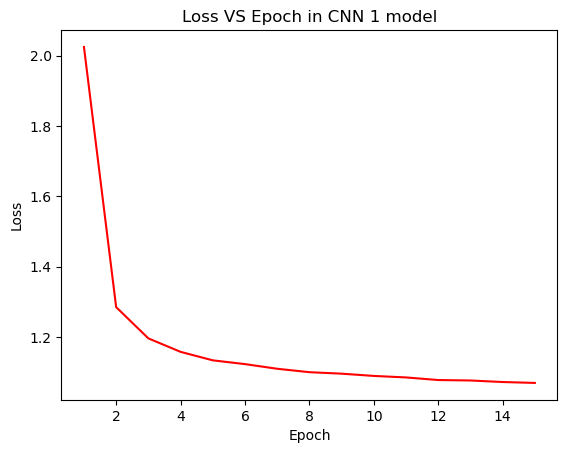

In [9]:
plt.plot(train_epoch,trainAvgLossArr,color="red")
plt.title('Loss VS Epoch in CNN 1 model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

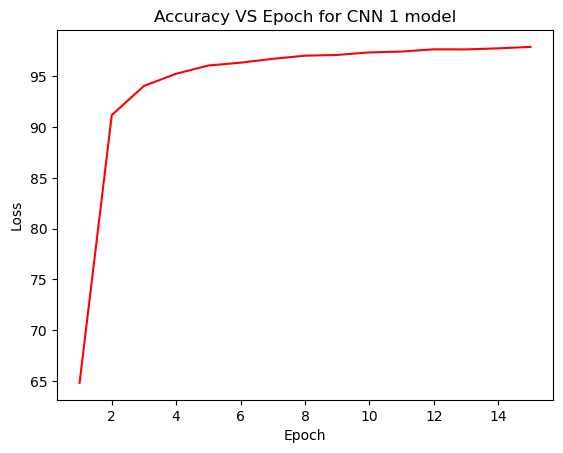

In [10]:
plt.plot(train_epoch,train_acc,color="red")
plt.title('Accuracy VS Epoch for CNN 1 model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [11]:
def testFunc(model):
    model.eval()
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        n_class_correct = [0 for i in range(10)]
        n_class_samples = [0 for i in range(10)]
        for test_images, test_labels in test_loader:
            outputs = model(test_images)
            _, predicted = torch.max(outputs, 1)  # max returns (value ,index)
            n_samples += test_labels.size(0)
            n_correct += (predicted == test_labels).sum().item()
            
            for i in range(100):
                label = test_labels[i]
                pred = predicted[i]
                if (label == pred):
                    n_class_correct[label] += 1
                n_class_samples[label] += 1

        netTest_acc1 = 100.0 * n_correct / n_samples
        print(f'Accuracy of the network: {netTest_acc1} %')

        for i in range(10):
            acc = 100.0 * n_class_correct[i] / n_class_samples[i]
            print(f'Accuracy of {i}: {acc} %')
    
    return netTest_acc1

In [12]:
cnn1_Test_Acc = testFunc(cnn1)

Accuracy of the network: 98.72 %
Accuracy of 0: 99.48979591836735 %
Accuracy of 1: 99.55947136563877 %
Accuracy of 2: 98.54651162790698 %
Accuracy of 3: 99.10891089108911 %
Accuracy of 4: 98.98167006109979 %
Accuracy of 5: 98.20627802690584 %
Accuracy of 6: 98.74739039665971 %
Accuracy of 7: 98.92996108949416 %
Accuracy of 8: 97.94661190965093 %
Accuracy of 9: 97.52229930624381 %


In [13]:
class CNN2(nn.Module):
    def __init__(self,):
        super(CNN2, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size) 
        self.pool = nn.MaxPool2d(2, 2) 
        self.conv2 = nn.Conv2d(10, 20, kernel_size) 
        self.fc1 = nn.Linear(20*kernel_size*kernel_size, 50) 
        self.fc2 = nn.Linear(50,50)
        self.fc3 = nn.Linear(50,30)
        self.fc4 = nn.Linear(30,20)
        self.fc5 = nn.Linear(20, 10)

    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))  
        x = self.pool(F.relu(self.conv2(x)))  
        x = x.view(-1, 320)           
        x = F.relu(self.fc1(x))              
        x = F.relu(self.fc2(x))        
        x = F.relu(self.fc3(x))        
        x = F.relu(self.fc4(x))        
         
        x = self.fc5(x)                       
        return x

In [14]:
torch.manual_seed(1)

cnn2 = CNN2()
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn2.parameters(), lr=learning_rate, weight_decay = weight_decay_val)

a=[]

for i in cnn2.parameters():
    a.append(torch.numel(i))
print('Total no of parameters in Model 2:', np.sum(a),)

Total no of parameters in Model 2: 24350


In [15]:
train_epoch2,train_losses2,train_acc2,trainAvgLossArr2=trainFunc(cnn2,max_epochs)

Max Epoch Reached, Loss: 0.0695, Accuracy:97.928000%


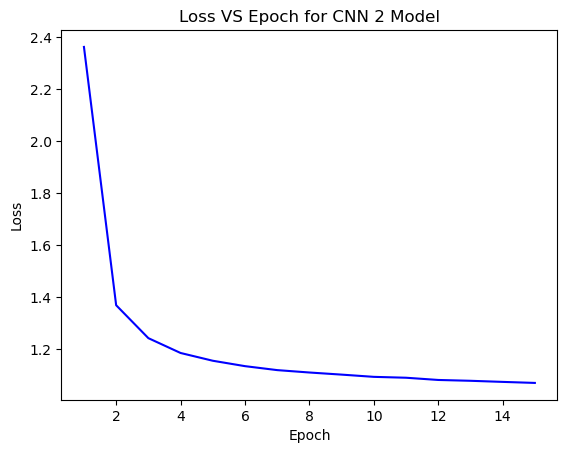

In [16]:
plt.plot(train_epoch2,trainAvgLossArr2,color="blue")
plt.title('Loss VS Epoch for CNN 2 Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

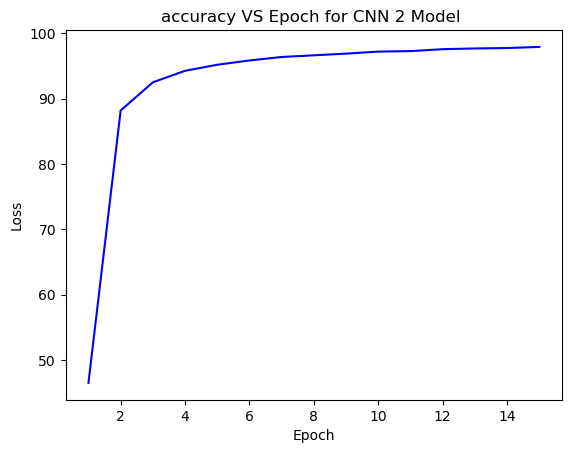

In [17]:
plt.plot(train_epoch2,train_acc2,color="Blue")
plt.title('accuracy VS Epoch for CNN 2 Model ')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [18]:
cnn2_Test_Acc = testFunc(cnn2)

Accuracy of the network: 97.96 %
Accuracy of 0: 99.48979591836735 %
Accuracy of 1: 99.73568281938326 %
Accuracy of 2: 98.74031007751938 %
Accuracy of 3: 97.52475247524752 %
Accuracy of 4: 98.57433808553971 %
Accuracy of 5: 98.09417040358744 %
Accuracy of 6: 98.01670146137788 %
Accuracy of 7: 96.10894941634241 %
Accuracy of 8: 96.20123203285421 %
Accuracy of 9: 96.92765113974232 %


In [19]:
class CNN3(nn.Module):
    def __init__(self,): 
        super(CNN3, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 15, 5)
        self.fc1 = nn.Linear(15*4*4, 80)
        self.fc2 = nn.Linear(80, 10)
       

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
     
        x = x.view(-1, 15*4*4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [20]:
torch.manual_seed(1)

cnn3 = CNN3()
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn3.parameters(), lr=learning_rate, weight_decay = weight_decay_val)

acc=[]

for i in cnn3.parameters():
    acc.append(torch.numel(i))
print('Total no of parameters in Model 3:', np.sum(acc))

Total no of parameters in Model 3: 24115


In [21]:
train_epoch3,train_losses3,train_acc3,trainAvgLossArr3=trainFunc(cnn3,max_epochs)

Max Epoch Reached, Loss: 0.0434, Accuracy:98.810000%


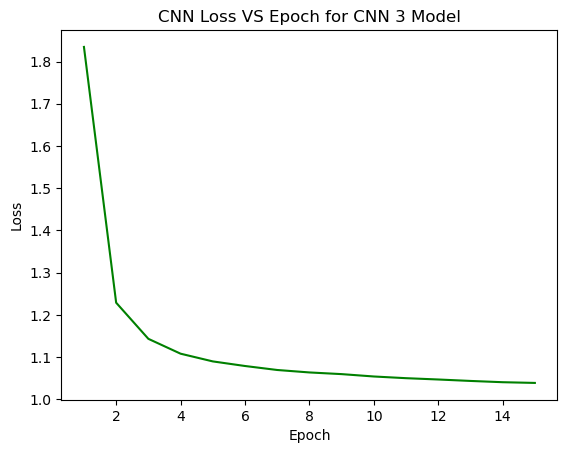

In [22]:
plt.plot(train_epoch3,trainAvgLossArr3,color="Green")
plt.title('CNN Loss VS Epoch for CNN 3 Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

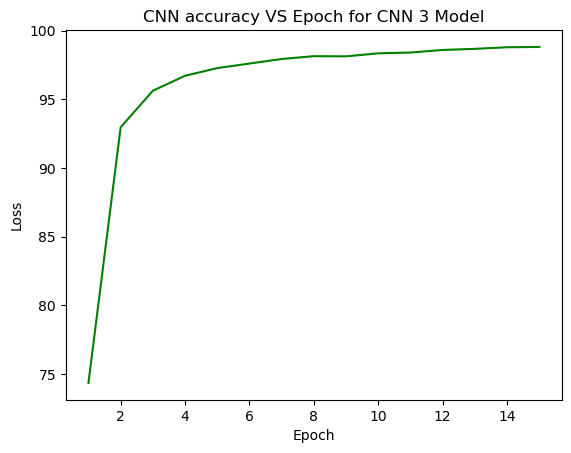

In [23]:
plt.plot(train_epoch3,train_acc3,color="Green")
plt.title('CNN accuracy VS Epoch for CNN 3 Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [24]:
cnn3_Test_Acc = testFunc(cnn3)

Accuracy of the network: 98.52 %
Accuracy of 0: 99.48979591836735 %
Accuracy of 1: 98.23788546255507 %
Accuracy of 2: 98.25581395348837 %
Accuracy of 3: 98.81188118811882 %
Accuracy of 4: 99.08350305498982 %
Accuracy of 5: 98.65470852017937 %
Accuracy of 6: 98.01670146137788 %
Accuracy of 7: 99.12451361867704 %
Accuracy of 8: 98.56262833675565 %
Accuracy of 9: 97.02675916749257 %


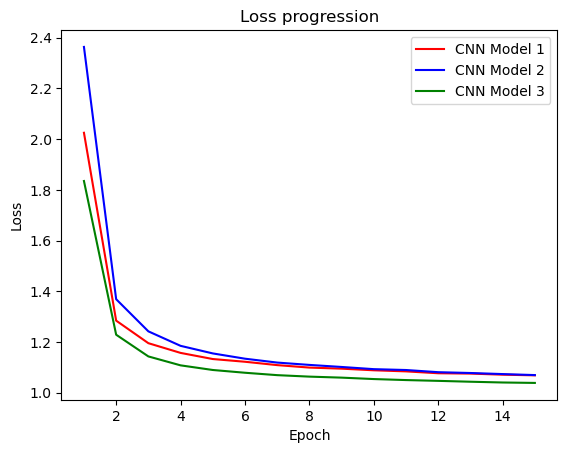

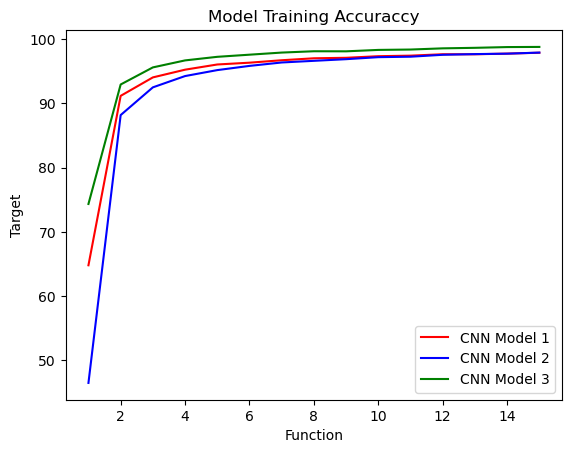

CNN1 Test Accuracy: 98.72 % 
CNN2 Test Accuracy: 97.96 % 
CNN3 Test Accuracy: 98.52 %


In [25]:
plt.plot(train_epoch,trainAvgLossArr, color = "Red")
plt.plot(train_epoch2,trainAvgLossArr2, color = "Blue")
plt.plot(train_epoch3,trainAvgLossArr3, color = "Green")
plt.title('Loss progression')
plt.legend(['CNN Model 1', 'CNN Model 2','CNN Model 3'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(train_epoch,train_acc,color="Red")
plt.plot(train_epoch2,train_acc2,color="Blue")
plt.plot(train_epoch3,train_acc3,color="Green")
plt.title('Model Training Accuraccy')
plt.legend(['CNN Model 1', 'CNN Model 2','CNN Model 3'])
plt.xlabel('Function')
plt.ylabel('Target')
plt.show()

print('CNN1 Test Accuracy:',cnn1_Test_Acc,'%','\nCNN2 Test Accuracy:',cnn2_Test_Acc,'%','\nCNN3 Test Accuracy:', cnn3_Test_Acc, "%")